Running on cuda | Evaluating model: cnn_gru_residual_lag_best.pt
Loaded 50 video samples
Model loaded successfully!


Evaluating: 100%|███████████████████████████████| 50/50 [00:04<00:00, 11.46it/s]



=== Quantitative Summary ===
           MSE  SpearmanR     dMAE   PeakF1
count  50.0000    50.0000  50.0000  50.0000
mean    0.0544     0.1896   0.0781   0.2622
std     0.0156     0.1247   0.0213   0.1347
min     0.0290    -0.0331   0.0480   0.0000
25%     0.0429     0.1162   0.0634   0.1681
50%     0.0512     0.1855   0.0720   0.2727
75%     0.0641     0.2616   0.0885   0.3442
max     0.0904     0.5486   0.1372   0.5652

Top 5 videos by Spearman correlation:
                      Video       MSE  SpearmanR      dMAE    PeakF1
27  XzYM3PfTM4w_aligned.npz  0.090427   0.548605  0.090822  0.363636
25  WxtbjNsCQ8A_aligned.npz  0.048344   0.478571  0.071224  0.461538
37  i3wAGJaaktw_aligned.npz  0.063610   0.410330  0.057286  0.199999
26  XkqCExn6_Us_aligned.npz  0.038160   0.364285  0.082409  0.333333
14  Hl-__g2gn_A_aligned.npz  0.043630   0.339279  0.087429  0.263157


/tmp/ipykernel_32496/3096596185.py:172: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([df["MSE"], df["SpearmanR"], df["dMAE"], df["PeakF1"]],


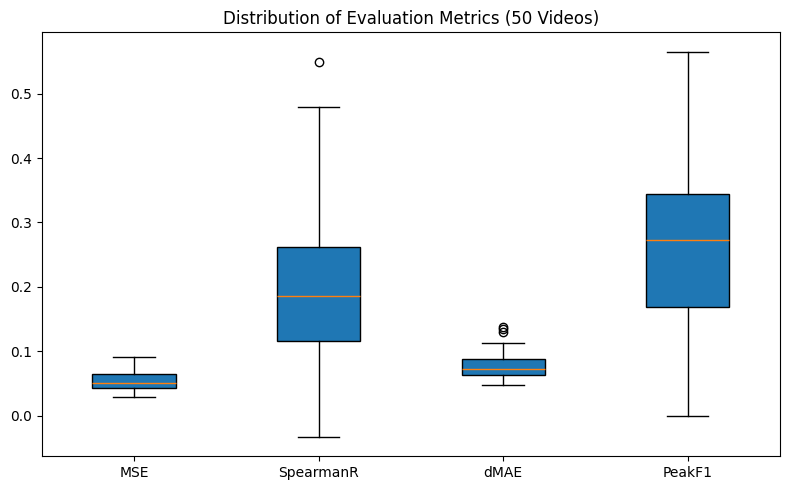


All per-video visualizations saved to: eval_results
Summary CSV saved as evaluation_summary.csv


In [1]:
# ===============================================================
# Evaluate_CNN_GRU_Residual_Lag.ipynb
# ---------------------------------------------------------------
# Comprehensive evaluation of CNN-GRU (Residual + Lag-aware loss)
# across all 50 training videos.
# ===============================================================

import os, glob, numpy as np, torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
from tqdm import tqdm

# ----------------------------
# Configuration
# ----------------------------
DATA_DIR   = "aligned_dataset_shifted"
MODEL_PATH = "cnn_gru_residual_lag_best.pt"
DEVICE     = "cuda" if torch.cuda.is_available() else "cpu"
WIN_LEN    = 128
STRIDE     = 64
MAX_SHIFT  = 2

print(f"Running on {DEVICE} | Evaluating model: {MODEL_PATH}")

# ----------------------------
# Dataset
# ----------------------------
class AttentionDataset(Dataset):
    def __init__(self, folder):
        self.files = sorted(glob.glob(os.path.join(folder, "*.npz")))
    def __len__(self): return len(self.files)
    def __getitem__(self, i):
        d = np.load(self.files[i], allow_pickle=True)
        X, y = d["X"].astype(np.float32), d["y"].astype(np.float32)
        X = (X - X.mean(0, keepdims=True)) / (X.std(0, keepdims=True) + 1e-6)
        y = (y - y.min()) / (y.max() - y.min() + 1e-6)
        return torch.from_numpy(X), torch.from_numpy(y), os.path.basename(self.files[i])

ds = AttentionDataset(DATA_DIR)
print(f"Loaded {len(ds)} video samples")

# ----------------------------
# Model (same as training)
# ----------------------------
class CNN_GRU_Residual(nn.Module):
    def __init__(self, in_dim, hidden=96):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(in_dim, hidden, 5, padding=2),
            nn.ReLU(),
            nn.Conv1d(hidden, hidden, 3, padding=1),
            nn.ReLU()
        )
        self.gru  = nn.GRU(hidden, hidden, num_layers=1, batch_first=True)
        self.fc   = nn.Linear(hidden, 1)
        self.skip = nn.Linear(in_dim, 1)
        self.drop = nn.Dropout(0.1)
    def forward(self, x):
        z = self.conv(x.transpose(1,2)).transpose(1,2)
        z, _ = self.gru(z)
        z = self.drop(z)
        y = self.fc(z).squeeze(-1)
        skip = self.skip(x).squeeze(-1)
        return 0.85*y + 0.15*skip

# ----------------------------
# Metrics
# ----------------------------
def derivative_loss(y_pred, y_true):
    return F.smooth_l1_loss(y_pred[:,1:] - y_pred[:,:-1],
                            y_true[:,1:] - y_true[:,:-1])

def shift_like(y, s):
    if s == 0: return y
    if s > 0:
        pad = y[:, :1].repeat(1, s)
        return torch.cat([pad, y[:, :-s]], dim=1)
    else:
        s = -s
        pad = y[:, -1:].repeat(1, s)
        return torch.cat([y[:, s:], pad], dim=1)

def lag_aware_mse(y_pred, y_true, max_shift=2):
    best = None
    for s in range(-max_shift, max_shift + 1):
        y_shift = shift_like(y_true, s)
        loss = ((y_pred - y_shift)**2).mean()
        best = loss if best is None else torch.minimum(best, loss)
    return best

def peak_f1(y_true, y_pred, tol=3, topk=0.1):
    yt, yp = y_true.flatten(), y_pred.flatten()
    k = max(1, int(len(yt) * topk))
    thr_t = torch.topk(yt, k).values.min()
    thr_p = torch.topk(yp, k).values.min()
    idx_t = torch.where(yt >= thr_t)[0]
    idx_p = torch.where(yp >= thr_p)[0]
    tp, used = 0, set()
    for i in idx_p.tolist():
        lo, hi = max(0, i - tol), min(len(yt) - 1, i + tol)
        cand = idx_t[(idx_t >= lo) & (idx_t <= hi)].tolist()
        if cand:
            j = min(cand, key=lambda c: abs(c - i))
            if j not in used:
                used.add(j); tp += 1
    fp = len(idx_p) - tp; fn = len(idx_t) - tp
    prec = tp / (tp + fp + 1e-6); rec = tp / (tp + fn + 1e-6)
    return 2 * prec * rec / (prec + rec + 1e-6)

# ----------------------------
# Load model
# ----------------------------
example_X, _, _ = ds[0]
model = CNN_GRU_Residual(example_X.shape[-1]).to(DEVICE)
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model.eval()
print("Model loaded successfully!")

# ----------------------------
# Evaluate all 50 videos
# ----------------------------
results = []
save_dir = "eval_results"
os.makedirs(save_dir, exist_ok=True)

for i in tqdm(range(len(ds)), desc="Evaluating"):
    X, Y, fname = ds[i]
    X, Y = X.to(DEVICE), Y.to(DEVICE)
    with torch.no_grad():
        yp = model(X.unsqueeze(0)).cpu().squeeze().numpy()
    yt = Y.cpu().numpy()
    # Clip for visualization
    yp_clip = np.clip(yp, 0, 1)

    # Plot
    plt.figure(figsize=(10,4))
    plt.plot(yt, label="Human", color="orange")
    plt.plot(yp_clip, label="Predicted", color="blue")
    plt.xlabel("Frames"); plt.ylabel("Attention (normalized)")
    plt.title(f"{fname} — CNN-GRU Residual Lag Model")
    plt.legend(); plt.tight_layout()
    plt.savefig(os.path.join(save_dir, f"{fname.replace('.npz','')}.png"), dpi=120)
    plt.close()

    # Compute metrics
    yt_t = torch.tensor(yt).unsqueeze(0)
    yp_t = torch.tensor(yp).unsqueeze(0)
    mse_val = ((yt_t - yp_t)**2).mean().item()
    rho_val, _ = spearmanr(yt, yp)
    dmae_val = torch.mean(torch.abs(torch.diff(yp_t) - torch.diff(yt_t))).item()
    pf1_val = float(peak_f1(yt_t, yp_t, tol=3, topk=0.1))
    results.append([fname, mse_val, rho_val, dmae_val, pf1_val])

# ----------------------------
# Quantitative Summary
# ----------------------------
import pandas as pd
df = pd.DataFrame(results, columns=["Video", "MSE", "SpearmanR", "dMAE", "PeakF1"])
df.to_csv("evaluation_summary.csv", index=False)

print("\n=== Quantitative Summary ===")
print(df.describe().round(4))

print("\nTop 5 videos by Spearman correlation:")
print(df.sort_values("SpearmanR", ascending=False).head())

# ----------------------------
# Aggregate Visualization
# ----------------------------
plt.figure(figsize=(8,5))
plt.boxplot([df["MSE"], df["SpearmanR"], df["dMAE"], df["PeakF1"]],
            labels=["MSE", "SpearmanR", "dMAE", "PeakF1"], patch_artist=True)
plt.title("Distribution of Evaluation Metrics (50 Videos)")
plt.tight_layout()
plt.savefig("aggregate_metrics_boxplot.png", dpi=150)
plt.show()

print("\nAll per-video visualizations saved to:", save_dir)
print("Summary CSV saved as evaluation_summary.csv")


Running on cuda | Evaluating model: cnn_gru_residual_lag_best.pt
Loaded 50 video samples
Model loaded successfully!


Evaluating videos:   0%|                                 | 0/50 [00:00<?, ?it/s]

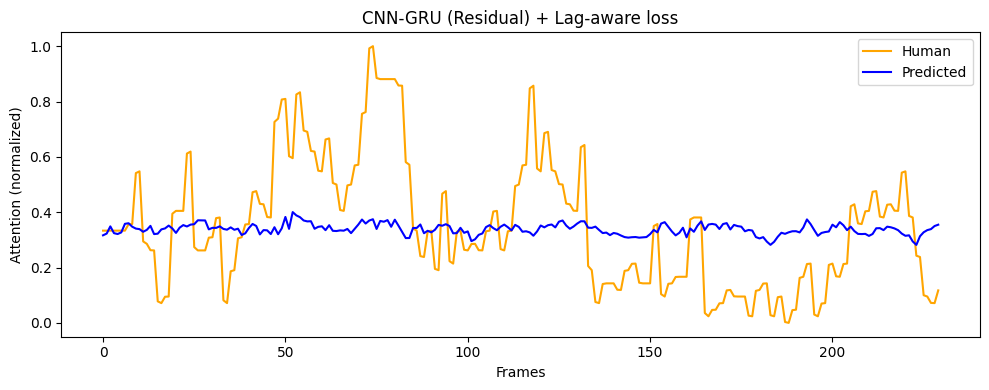

Evaluating videos:   2%|▌                        | 1/50 [00:00<00:13,  3.63it/s]

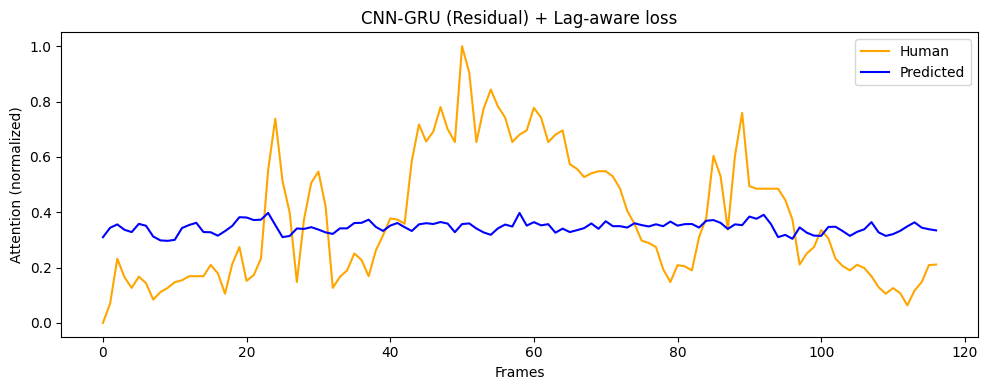

Evaluating videos:   4%|█                        | 2/50 [00:00<00:10,  4.53it/s]

Evaluating videos:   6%|█▌                       | 3/50 [00:00<00:09,  4.76it/s]

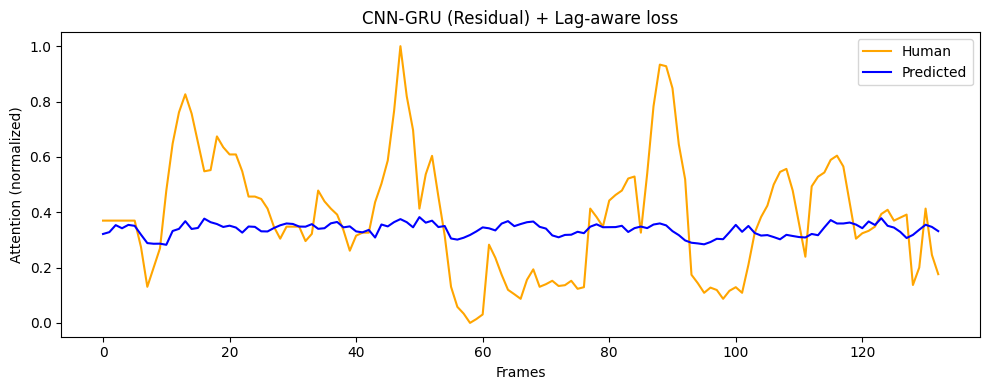

Evaluating videos:  10%|██▌                      | 5/50 [00:00<00:05,  8.03it/s]

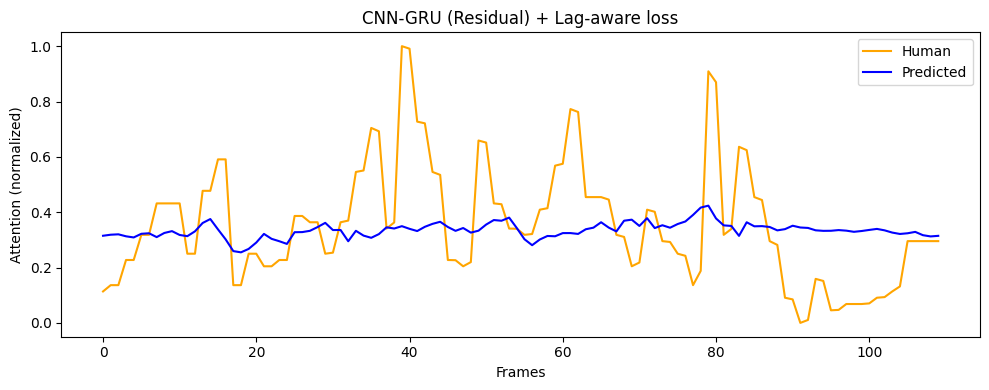

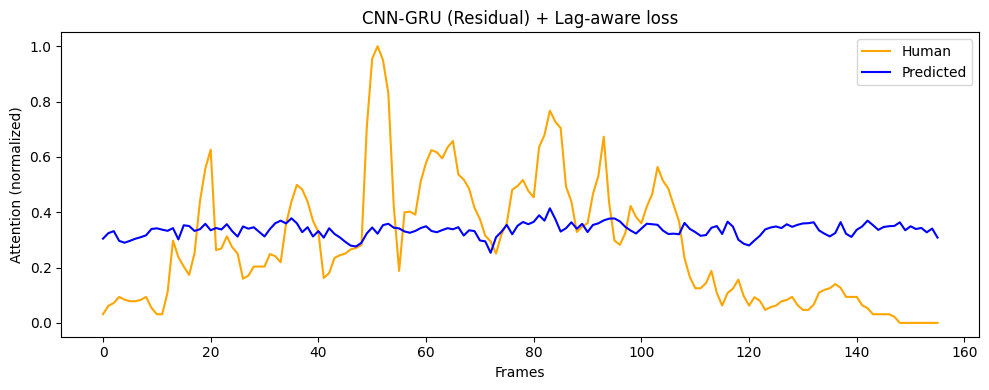

Evaluating videos:  14%|███▌                     | 7/50 [00:00<00:04, 10.57it/s]

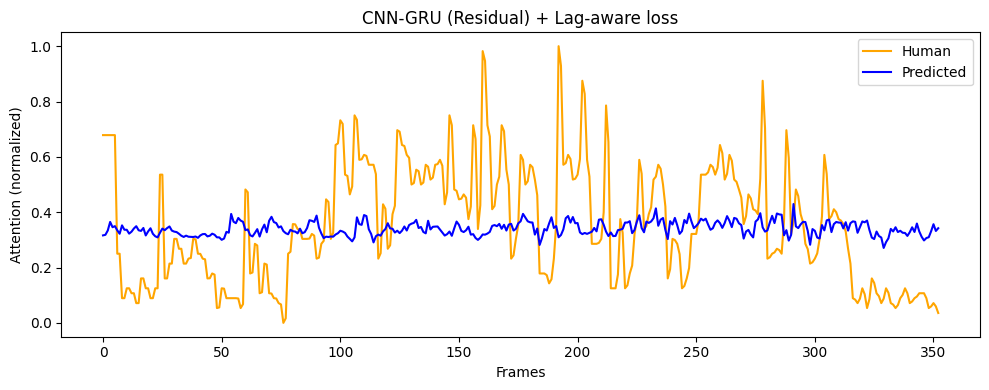

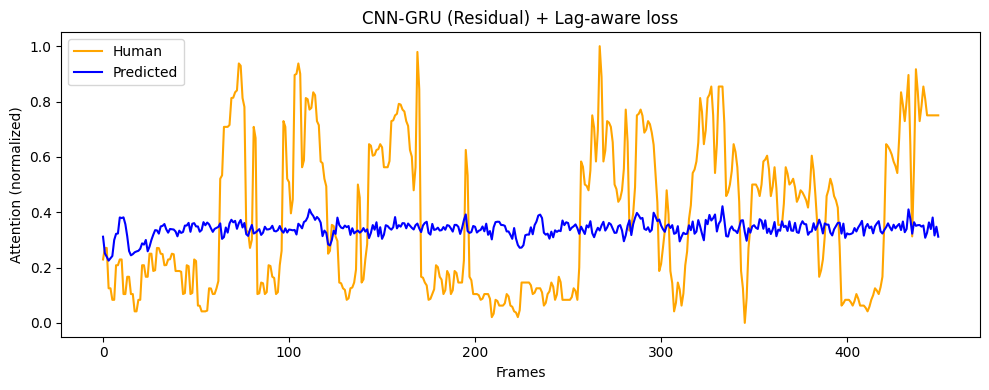

Evaluating videos:  18%|████▌                    | 9/50 [00:01<00:03, 12.39it/s]

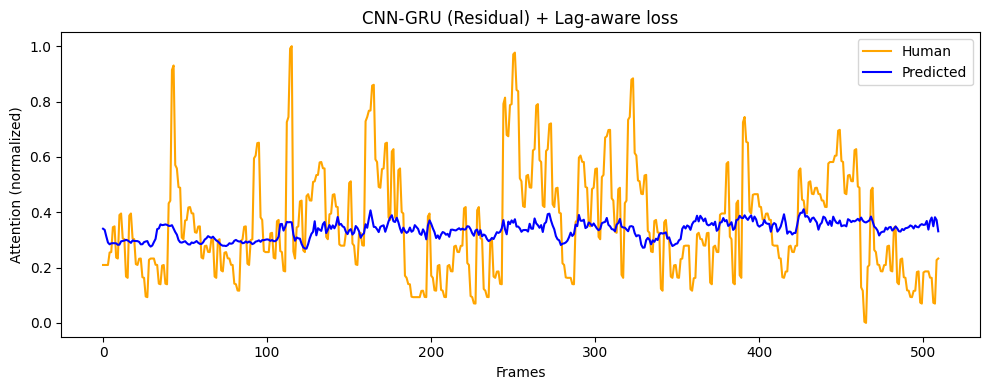

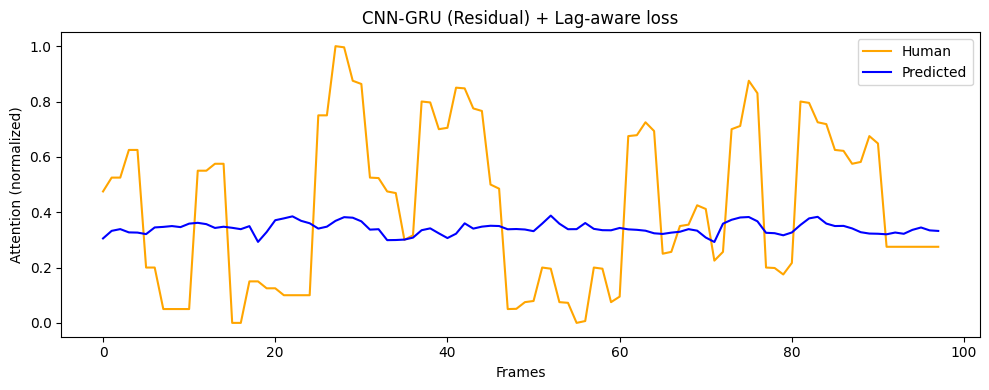

Evaluating videos:  22%|█████▎                  | 11/50 [00:01<00:02, 13.81it/s]

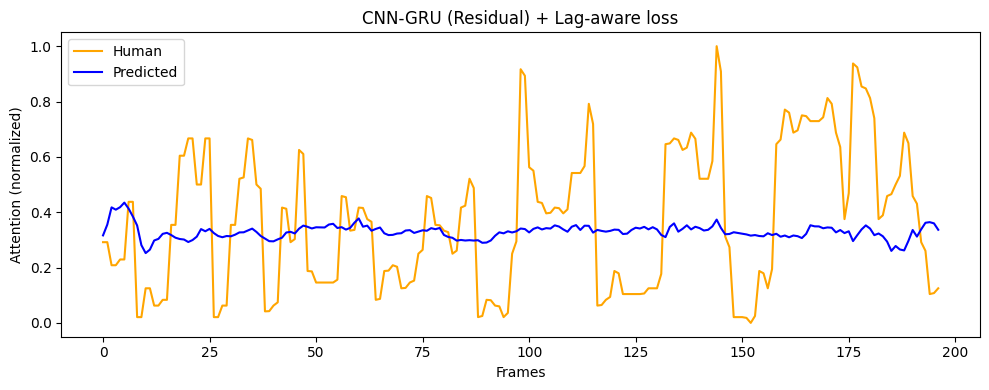

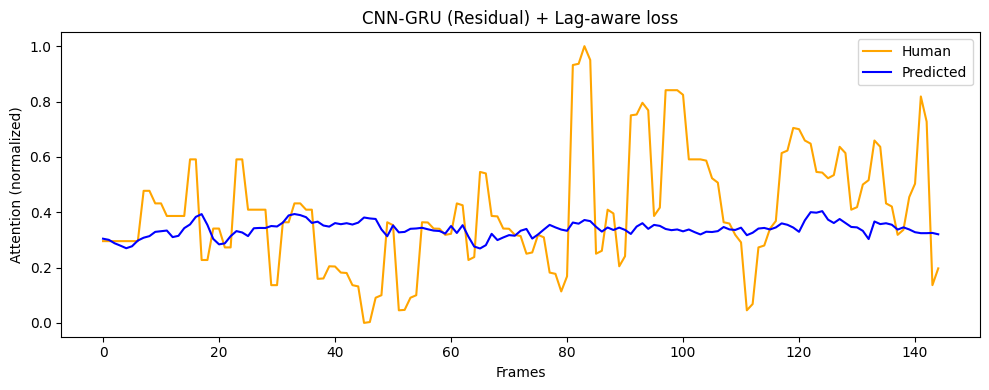

Evaluating videos:  26%|██████▏                 | 13/50 [00:01<00:03, 11.44it/s]

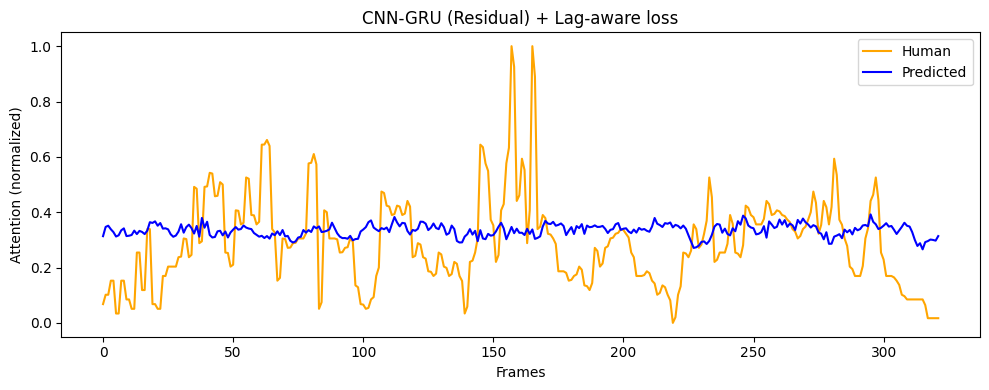

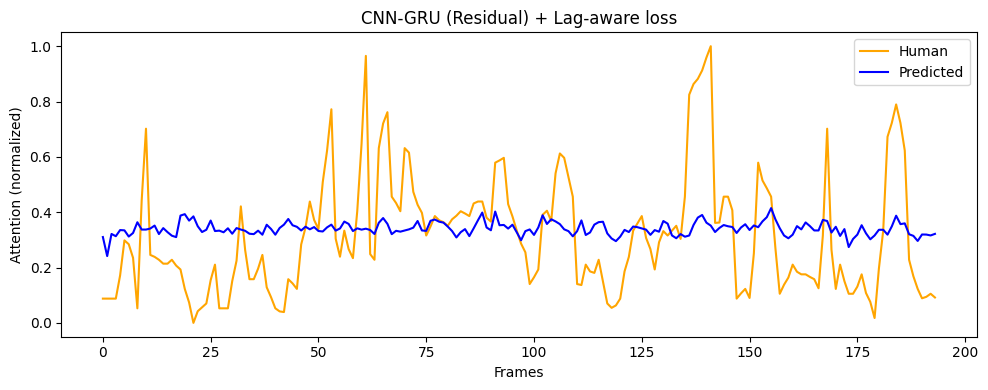

Evaluating videos:  30%|███████▏                | 15/50 [00:01<00:03, 10.15it/s]

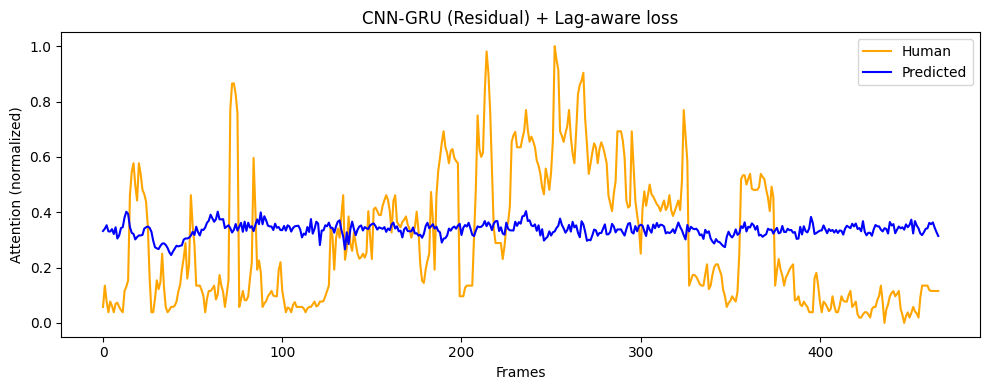

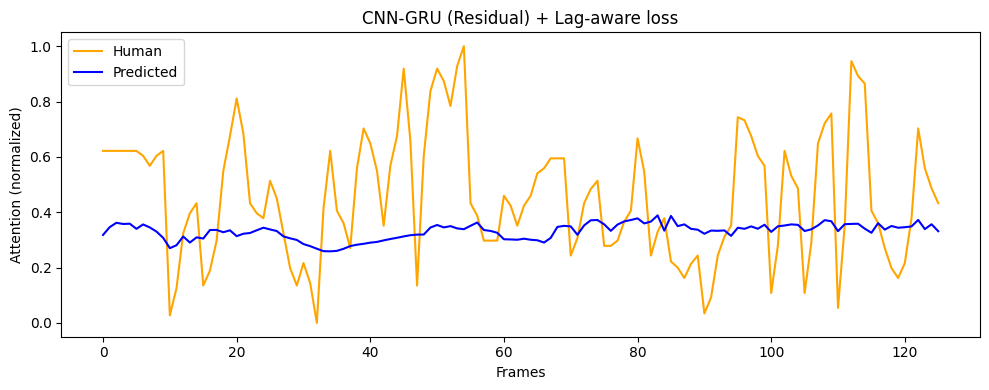

Evaluating videos:  34%|████████▏               | 17/50 [00:01<00:03,  9.29it/s]

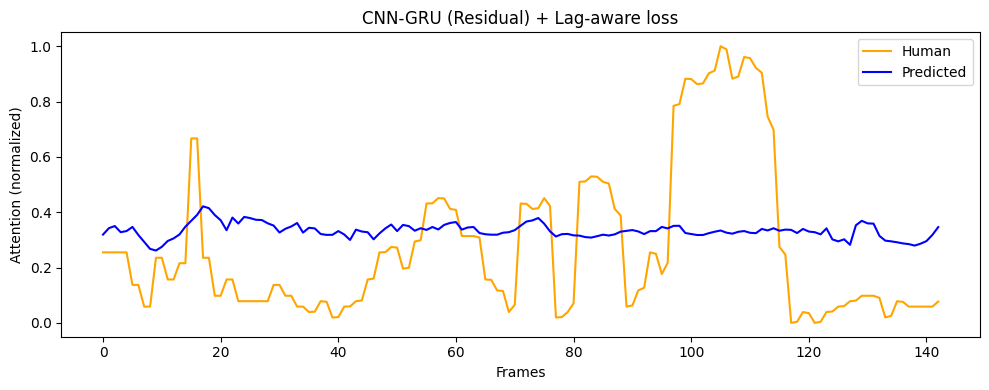

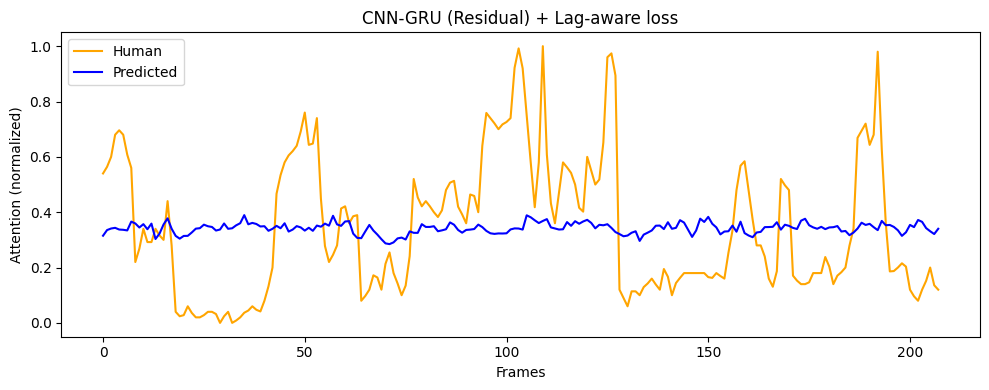

Evaluating videos:  38%|█████████               | 19/50 [00:02<00:03,  9.47it/s]

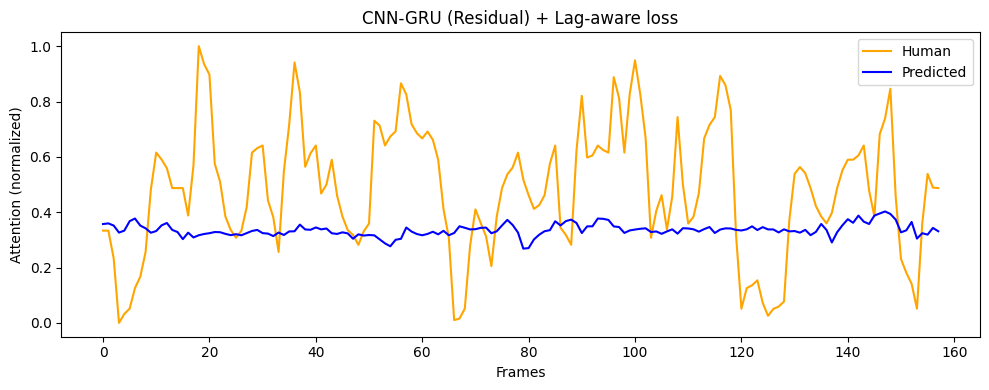

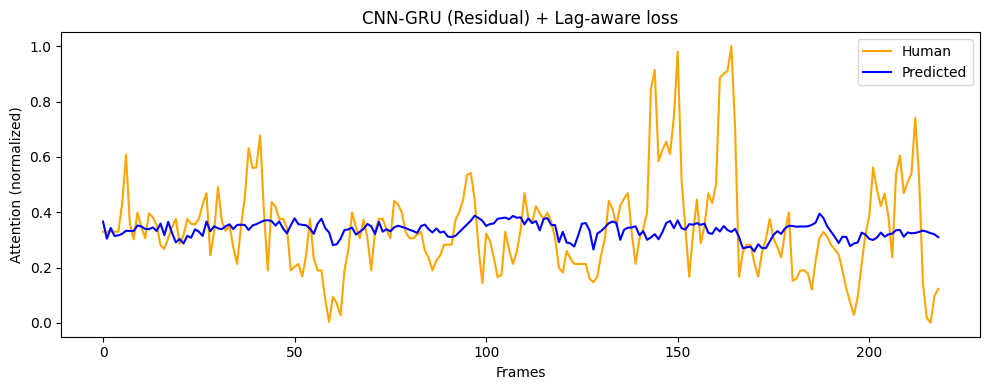

Evaluating videos:  42%|██████████              | 21/50 [00:02<00:02, 11.02it/s]

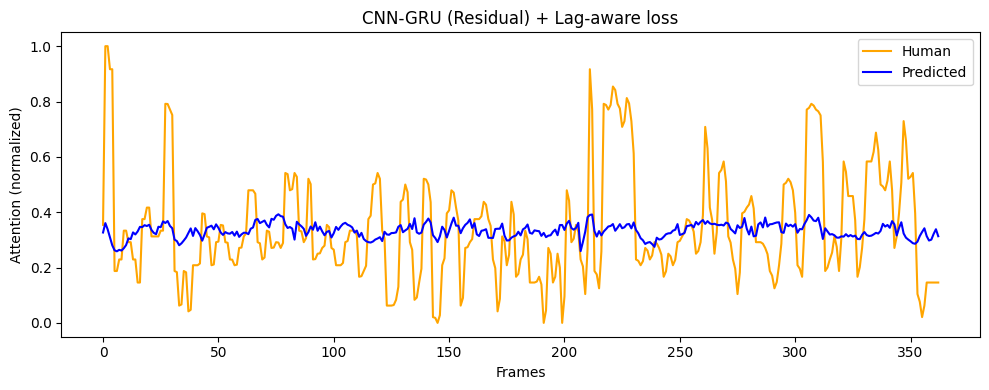

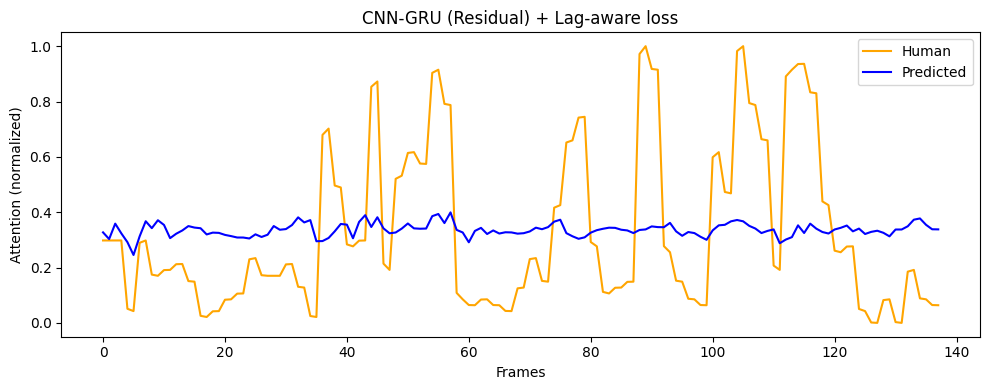

Evaluating videos:  46%|███████████             | 23/50 [00:02<00:02, 10.09it/s]

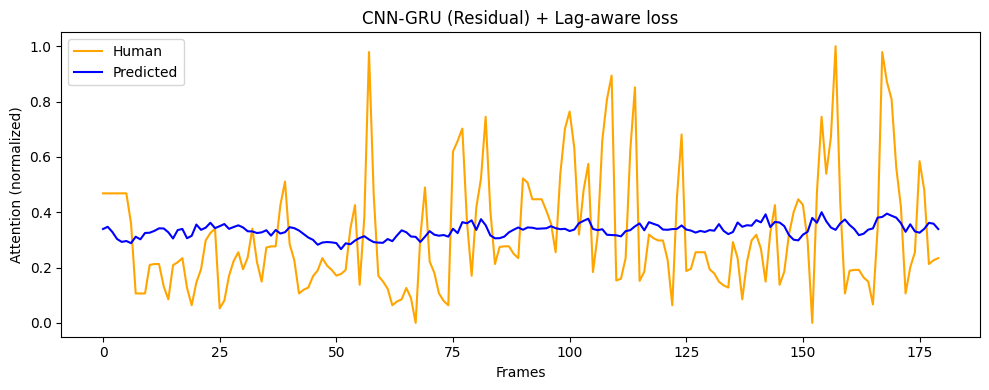

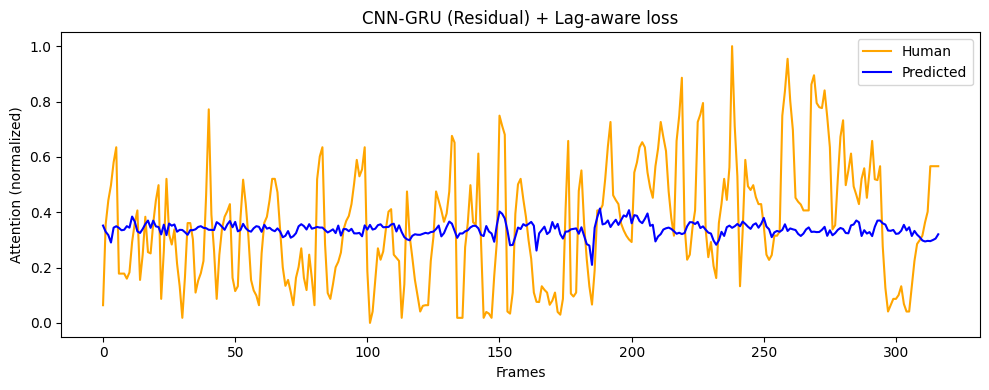

Evaluating videos:  50%|████████████            | 25/50 [00:02<00:02, 11.44it/s]

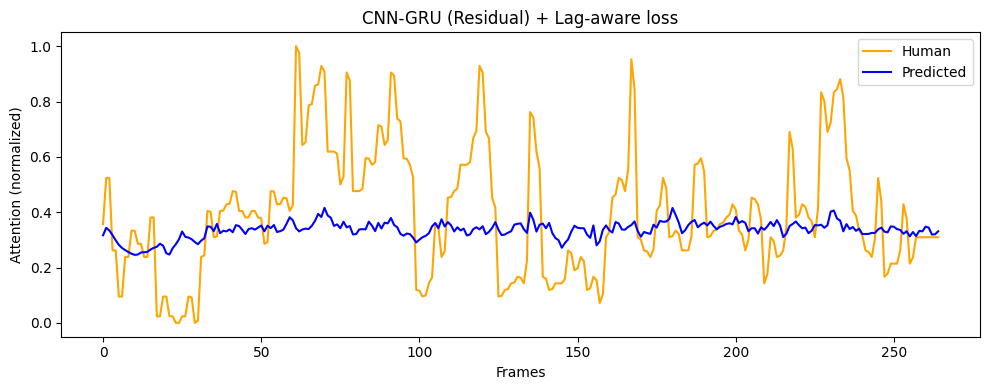

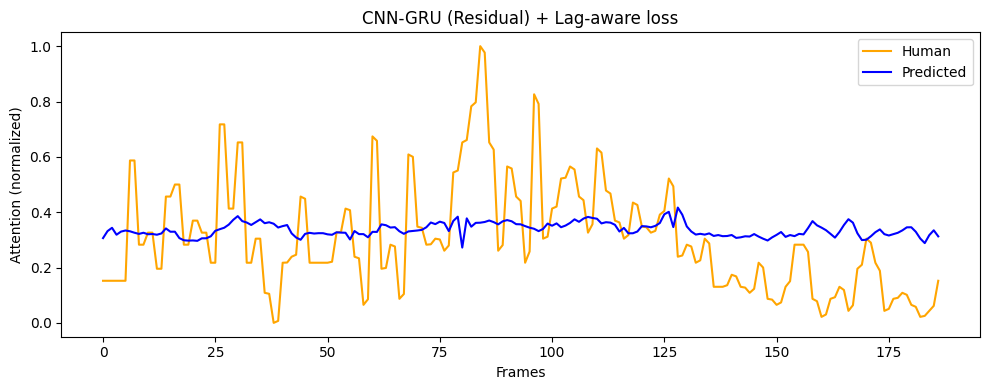

Evaluating videos:  54%|████████████▉           | 27/50 [00:02<00:02, 10.08it/s]

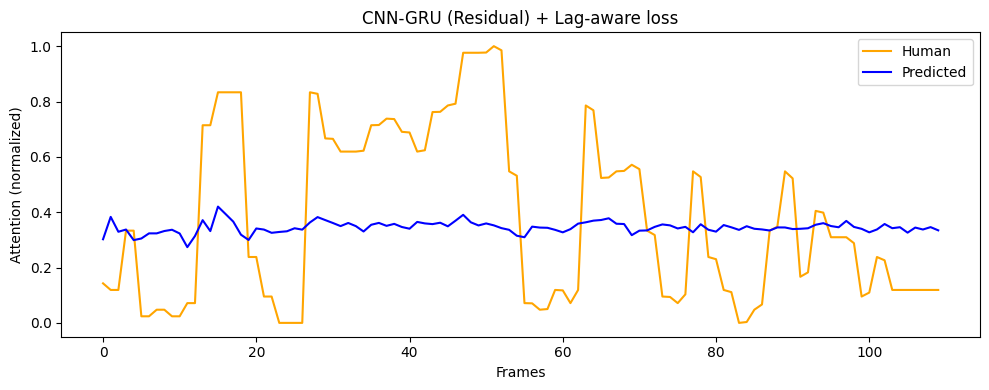

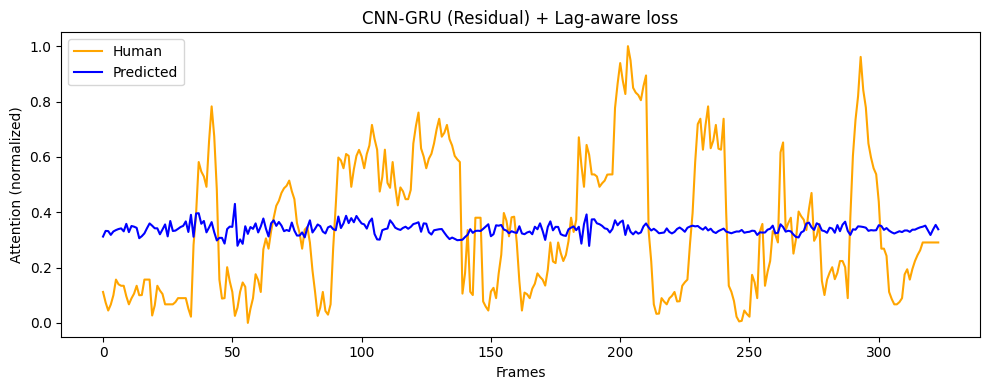

Evaluating videos:  58%|█████████████▉          | 29/50 [00:03<00:02,  8.87it/s]

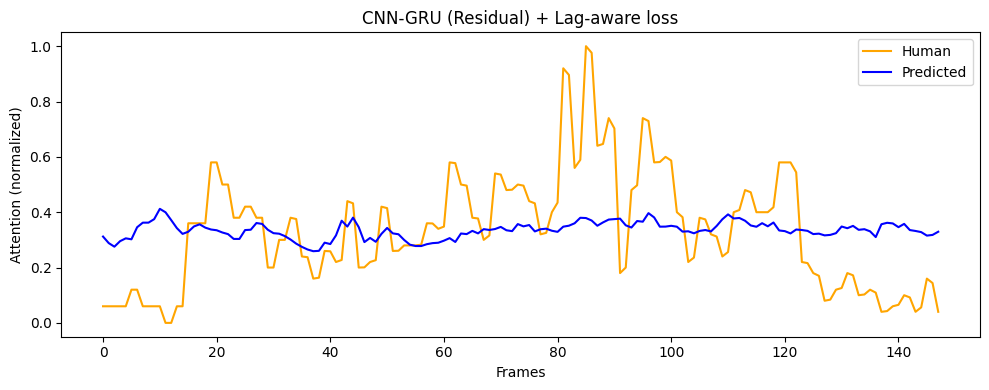

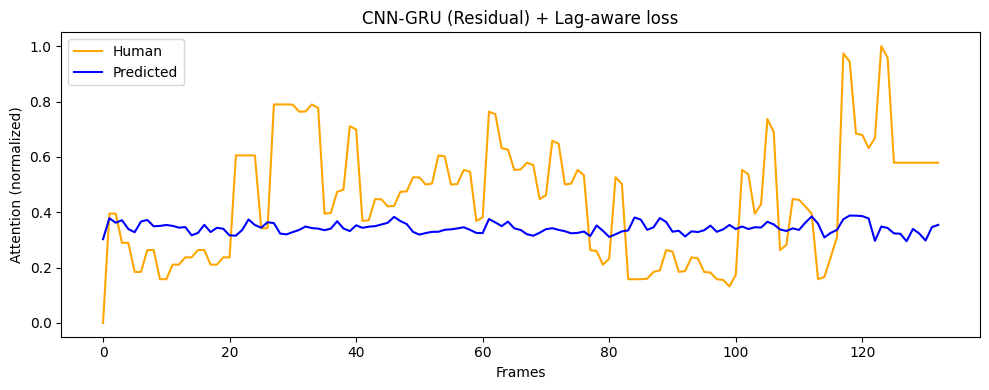

Evaluating videos:  62%|██████████████▉         | 31/50 [00:03<00:02,  8.77it/s]

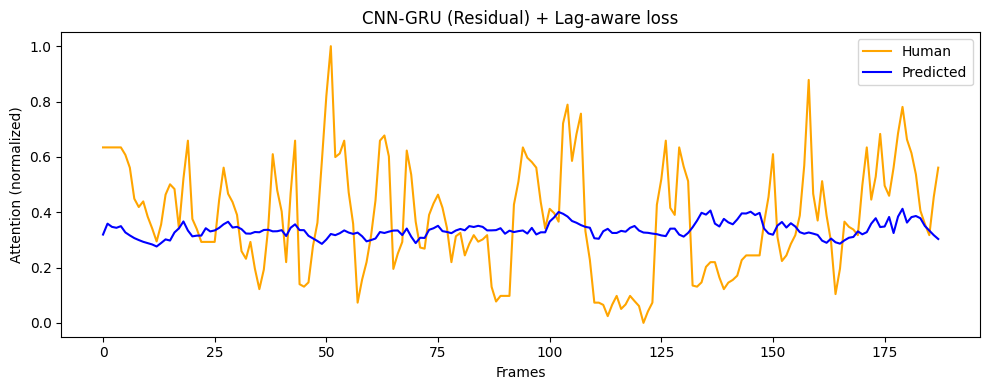

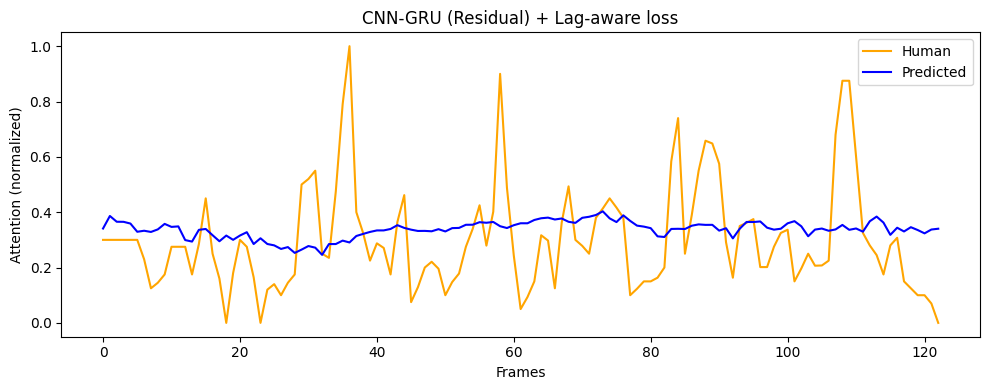

Evaluating videos:  66%|███████████████▊        | 33/50 [00:03<00:01, 10.28it/s]

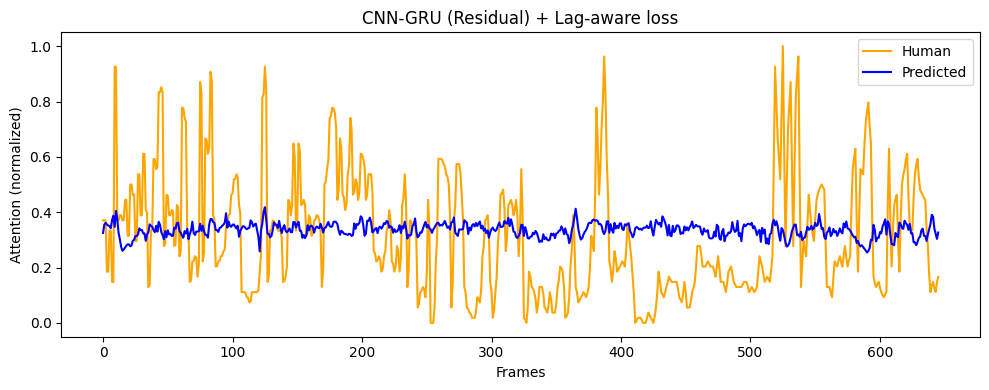

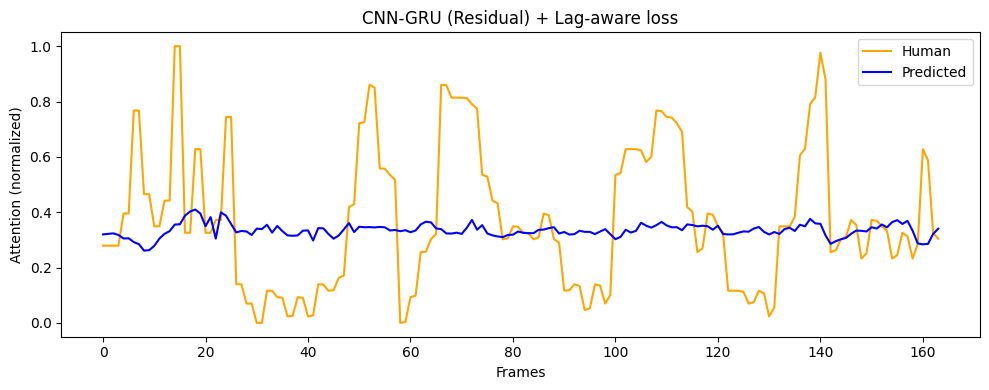

Evaluating videos:  70%|████████████████▊       | 35/50 [00:03<00:01,  8.22it/s]

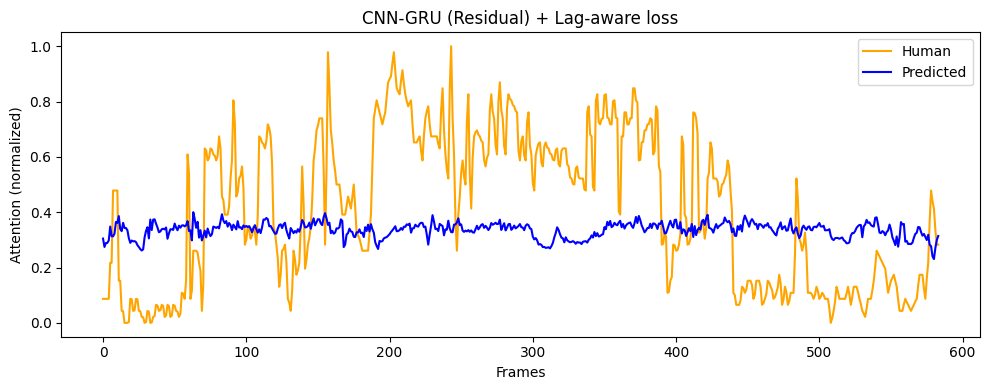

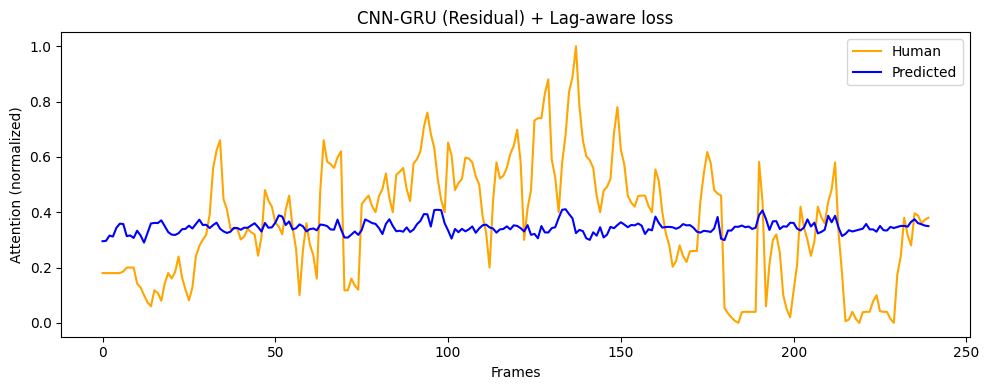

Evaluating videos:  74%|█████████████████▊      | 37/50 [00:03<00:01,  9.30it/s]

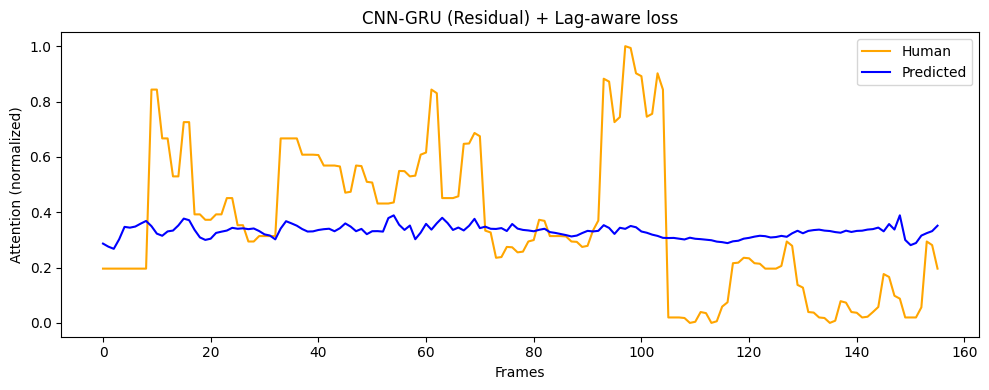

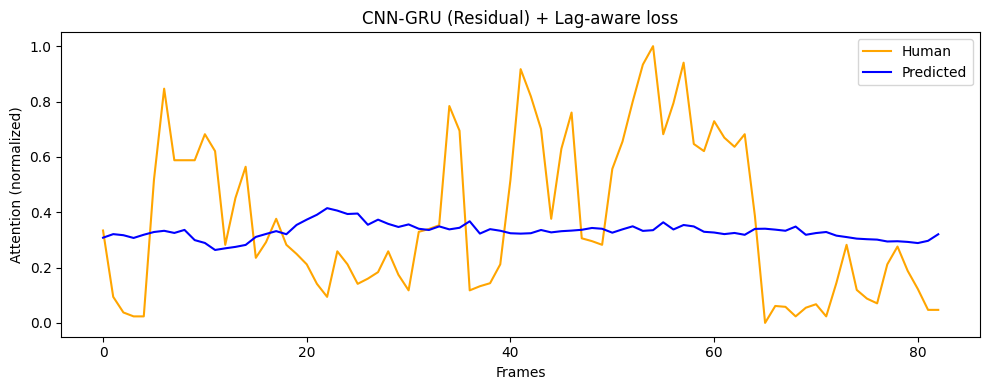

Evaluating videos:  78%|██████████████████▋     | 39/50 [00:04<00:01, 10.86it/s]

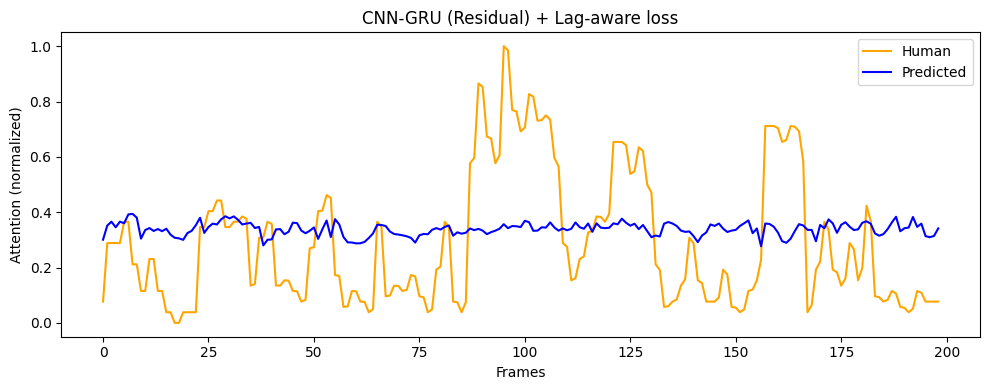

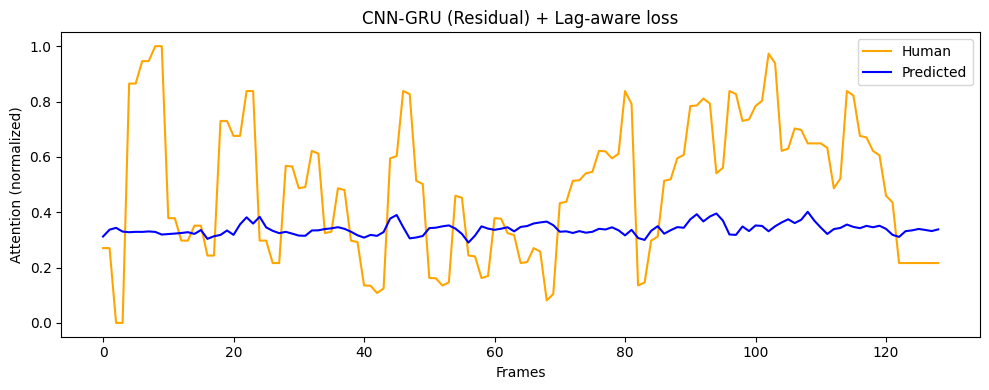

Evaluating videos:  82%|███████████████████▋    | 41/50 [00:04<00:00, 12.27it/s]

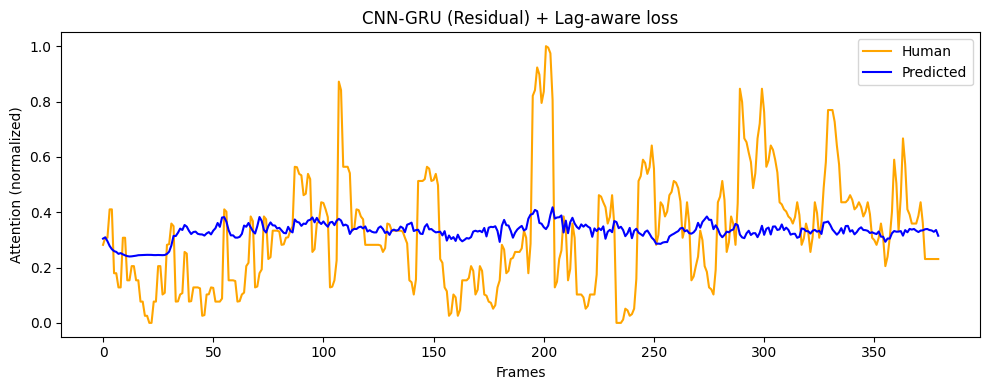

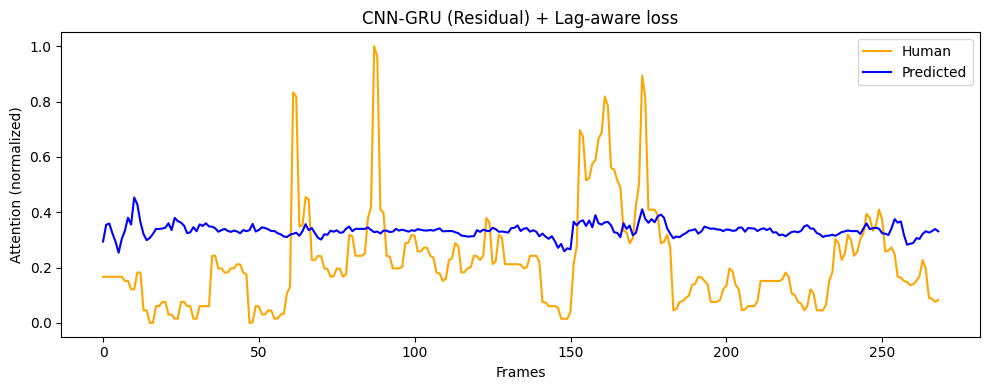

Evaluating videos:  86%|████████████████████▋   | 43/50 [00:04<00:00, 13.47it/s]

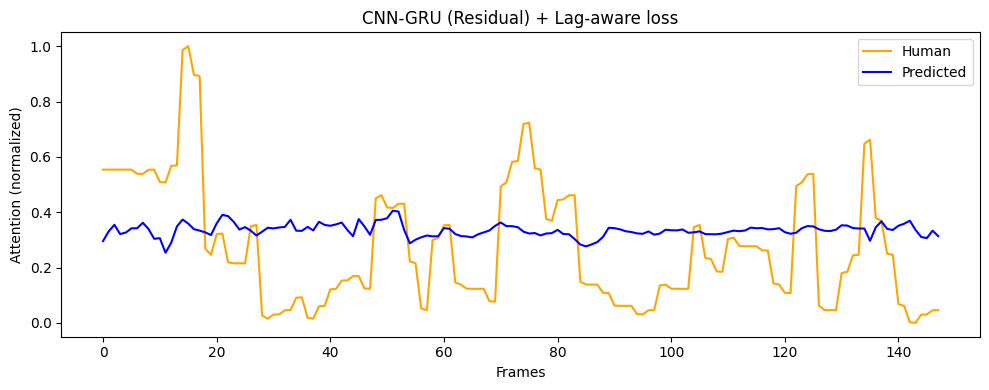

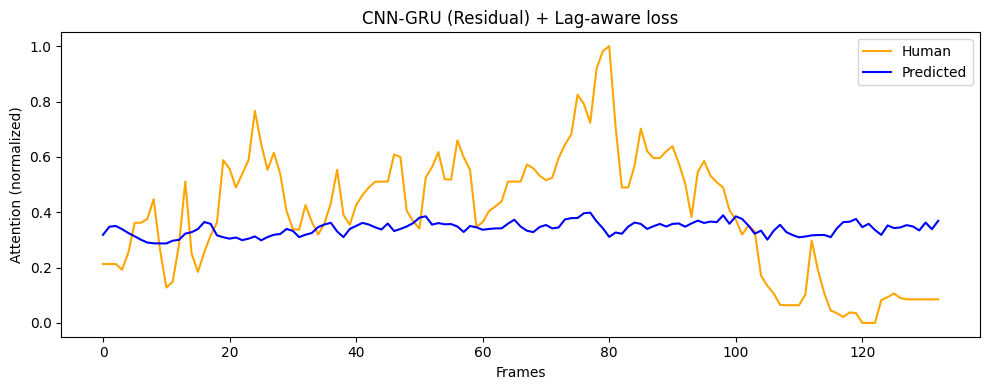

Evaluating videos:  90%|█████████████████████▌  | 45/50 [00:04<00:00, 11.57it/s]

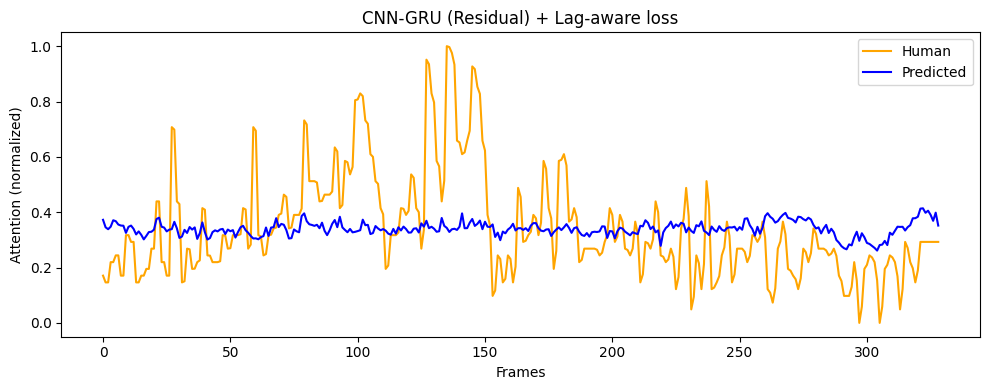

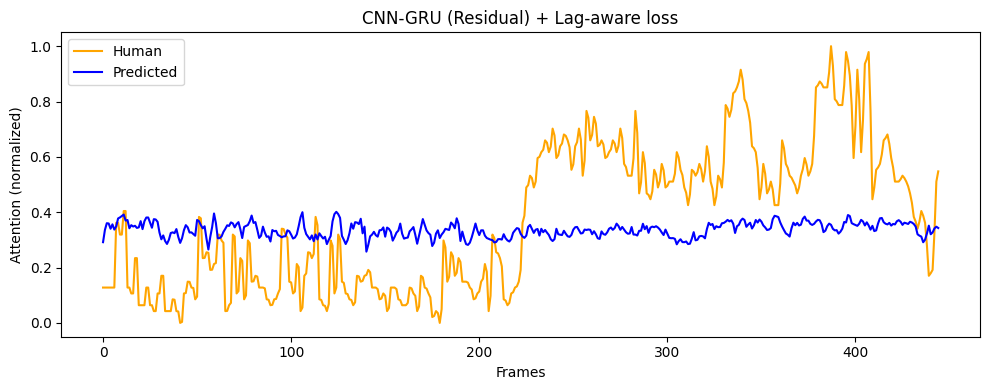

Evaluating videos:  94%|██████████████████████▌ | 47/50 [00:04<00:00, 12.81it/s]

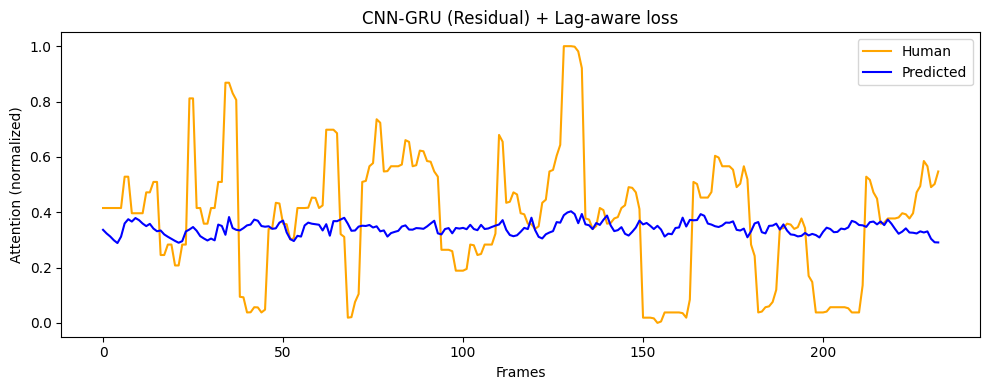

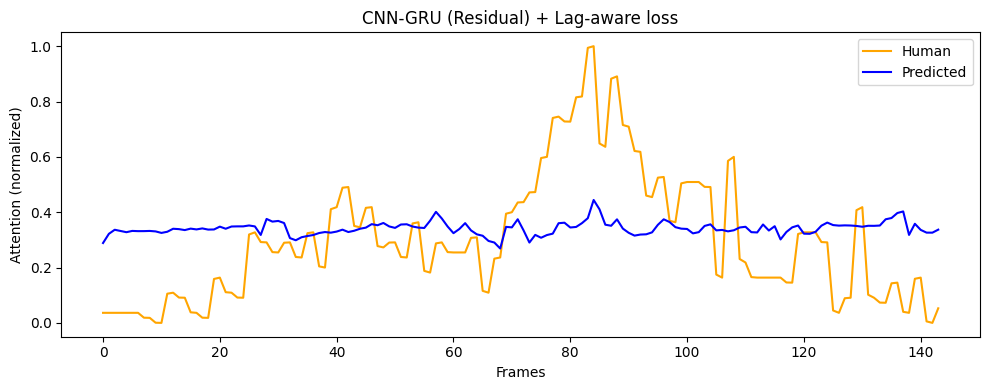

Evaluating videos:  98%|███████████████████████▌| 49/50 [00:04<00:00, 14.06it/s]

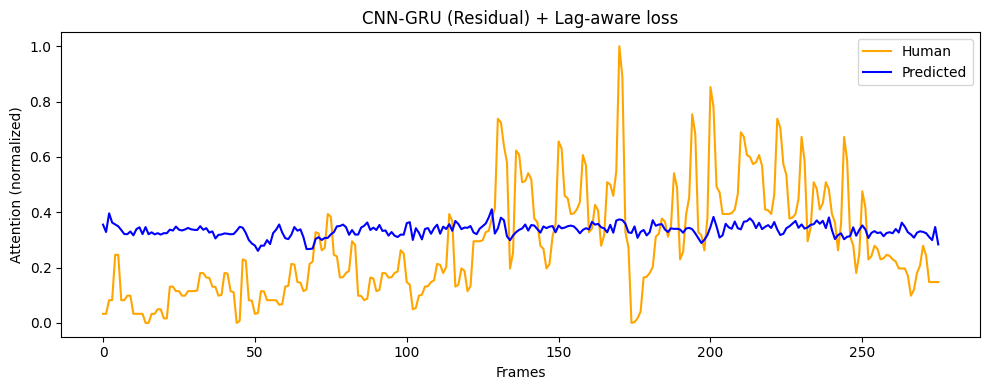

Evaluating videos: 100%|████████████████████████| 50/50 [00:04<00:00, 10.47it/s]
/tmp/ipykernel_32496/1036324286.py:143: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([df["MSE"], df["SpearmanR"], df["dMAE"], df["PeakF1"]],



=== Quantitative Summary (50 videos) ===
           MSE  SpearmanR     dMAE   PeakF1
count  50.0000    50.0000  50.0000  50.0000
mean    0.0544     0.1896   0.0781   0.2622
std     0.0156     0.1247   0.0213   0.1347
min     0.0290    -0.0331   0.0480   0.0000
25%     0.0429     0.1162   0.0634   0.1681
50%     0.0512     0.1855   0.0720   0.2727
75%     0.0641     0.2616   0.0885   0.3442
max     0.0904     0.5486   0.1372   0.5652


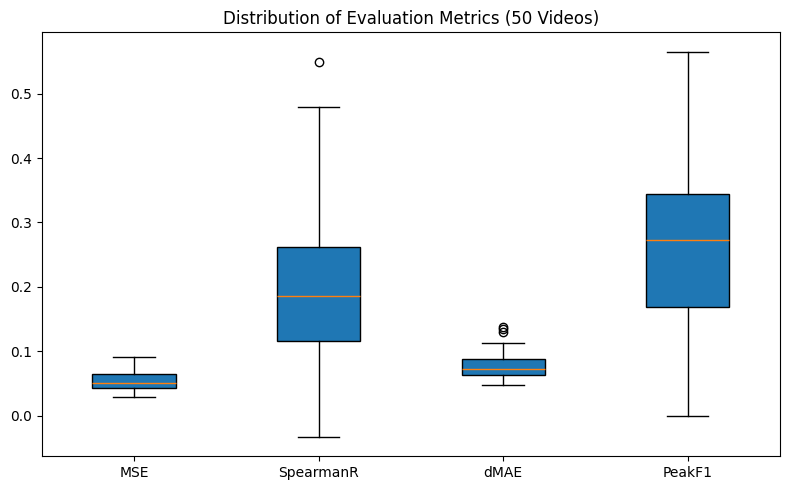


Per-video plots saved in: eval_results/
Summary CSV saved as: evaluation_summary.csv
Boxplot saved as: aggregate_metrics_boxplot.png


In [2]:
# ===============================================================
# Evaluate_CNN_GRU_Residual_Lag.ipynb
# ---------------------------------------------------------------
# Comprehensive evaluation of CNN-GRU (Residual + Lag-aware loss)
# across all 50 training videos — with per-video plots.
# ===============================================================

import os, glob, numpy as np, torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import Dataset
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd

# ----------------------------
# Configuration
# ----------------------------
DATA_DIR   = "aligned_dataset_shifted"
MODEL_PATH = "cnn_gru_residual_lag_best.pt"
DEVICE     = "cuda" if torch.cuda.is_available() else "cpu"
MAX_SHIFT  = 2

print(f"Running on {DEVICE} | Evaluating model: {MODEL_PATH}")

# ----------------------------
# Dataset
# ----------------------------
class AttentionDataset(Dataset):
    def __init__(self, folder):
        self.files = sorted(glob.glob(os.path.join(folder, "*.npz")))
    def __len__(self): return len(self.files)
    def __getitem__(self, i):
        d = np.load(self.files[i], allow_pickle=True)
        X, y = d["X"].astype(np.float32), d["y"].astype(np.float32)
        X = (X - X.mean(0, keepdims=True)) / (X.std(0, keepdims=True) + 1e-6)
        y = (y - y.min()) / (y.max() - y.min() + 1e-6)
        return torch.from_numpy(X), torch.from_numpy(y), os.path.basename(self.files[i])

ds = AttentionDataset(DATA_DIR)
print(f"Loaded {len(ds)} video samples")

# ----------------------------
# Model (same as training)
# ----------------------------
class CNN_GRU_Residual(nn.Module):
    def __init__(self, in_dim, hidden=96):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(in_dim, hidden, 5, padding=2),
            nn.ReLU(),
            nn.Conv1d(hidden, hidden, 3, padding=1),
            nn.ReLU()
        )
        self.gru  = nn.GRU(hidden, hidden, num_layers=1, batch_first=True, bidirectional=False)
        self.fc   = nn.Linear(hidden, 1)
        self.skip = nn.Linear(in_dim, 1)  # residual trend from raw features
        self.drop = nn.Dropout(0.1)

    def forward(self, x):                 # x: (B,T,F)
        z = self.conv(x.transpose(1,2)).transpose(1,2)  # (B,T,H)
        z, _ = self.gru(z)                               # (B,T,H)
        z = self.drop(z)
        y = self.fc(z).squeeze(-1)                       # (B,T)
        skip = self.skip(x).squeeze(-1)                  # (B,T)
        return 0.85 * y + 0.15 * skip                    # small residual blend

# ----------------------------
# Metrics
# ----------------------------
def peak_f1(y_true, y_pred, tol=3, topk=0.1):
    yt, yp = y_true.flatten(), y_pred.flatten()
    k = max(1, int(len(yt) * topk))
    thr_t = torch.topk(yt, k).values.min()
    thr_p = torch.topk(yp, k).values.min()
    idx_t = torch.where(yt >= thr_t)[0]
    idx_p = torch.where(yp >= thr_p)[0]
    tp, used = 0, set()
    for i in idx_p.tolist():
        lo, hi = max(0, i - tol), min(len(yt) - 1, i + tol)
        cand = idx_t[(idx_t >= lo) & (idx_t <= hi)].tolist()
        if cand:
            j = min(cand, key=lambda c: abs(c - i))
            if j not in used:
                used.add(j); tp += 1
    fp = len(idx_p) - tp; fn = len(idx_t) - tp
    prec = tp / (tp + fp + 1e-6); rec = tp / (tp + fn + 1e-6)
    return 2 * prec * rec / (prec + rec + 1e-6)

# ----------------------------
# Load model
# ----------------------------
example_X, _, _ = ds[0]
model = CNN_GRU_Residual(example_X.shape[-1]).to(DEVICE)
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model.eval()
print("Model loaded successfully!")

# ----------------------------
# Evaluate each video & plot
# ----------------------------
os.makedirs("eval_results", exist_ok=True)
results = []

for i in tqdm(range(len(ds)), desc="Evaluating videos"):
    X, Y, fname = ds[i]
    X, Y = X.to(DEVICE), Y.to(DEVICE)
    with torch.no_grad():
        pred = model(X.unsqueeze(0)).cpu().numpy().squeeze()
    Y = Y.cpu().numpy()
    pred_plot = np.clip(pred, 0, 1)

    # --- Visualization (same style as your example) ---
    plt.figure(figsize=(10,4))
    plt.plot(Y, label="Human", color="orange")
    plt.plot(pred_plot, label="Predicted", color="blue")
    plt.title("CNN-GRU (Residual) + Lag-aware loss")
    plt.xlabel("Frames")
    plt.ylabel("Attention (normalized)")
    plt.legend()
    plt.tight_layout()
    save_path = os.path.join("eval_results", f"{fname.replace('.npz','')}.png")
    # plt.savefig(save_path, dpi=150)
    plt.show()

    # --- Quantitative metrics ---
    yt_t = torch.tensor(Y).unsqueeze(0)
    yp_t = torch.tensor(pred).unsqueeze(0)
    mse_val = ((yt_t - yp_t)**2).mean().item()
    rho_val, _ = spearmanr(Y, pred)
    dmae_val = torch.mean(torch.abs(torch.diff(yp_t) - torch.diff(yt_t))).item()
    pf1_val = float(peak_f1(yt_t, yp_t, tol=3, topk=0.1))
    results.append([fname, mse_val, rho_val, dmae_val, pf1_val])

# ----------------------------
# Aggregate metrics
# ----------------------------
df = pd.DataFrame(results, columns=["Video", "MSE", "SpearmanR", "dMAE", "PeakF1"])
df.to_csv("evaluation_summary.csv", index=False)

print("\n=== Quantitative Summary (50 videos) ===")
print(df.describe().round(4))

plt.figure(figsize=(8,5))
plt.boxplot([df["MSE"], df["SpearmanR"], df["dMAE"], df["PeakF1"]],
            labels=["MSE", "SpearmanR", "dMAE", "PeakF1"], patch_artist=True)
plt.title("Distribution of Evaluation Metrics (50 Videos)")
plt.tight_layout()
plt.savefig("aggregate_metrics_boxplot.png", dpi=150)
plt.show()

print("\nPer-video plots saved in: eval_results/")
print("Summary CSV saved as: evaluation_summary.csv")
print("Boxplot saved as: aggregate_metrics_boxplot.png")


In [12]:
# ===============================================================
# train_cnn_gru_residual_lag.py
# ---------------------------------------------------------------
# Lightweight CNN+GRU with residual skip and lag-aware loss
# for micro-attention regression + per-video visualization.
# ===============================================================

import os, glob, numpy as np, torch, torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from scipy.stats import spearmanr
from tqdm import tqdm
import pandas as pd
import matplotlib
matplotlib.use("Agg")
import matplotlib.pyplot as plt

# ------------------
# Config
# ------------------
DATA_DIR   = "aligned_dataset_shifted"
DEVICE     = "cuda" if torch.cuda.is_available() else "cpu"
EPOCHS     = 100
LR         = 2e-3
BATCH_SIZE = 1
WIN_LEN    = 128
STRIDE     = 64
AMP        = True
MAX_SHIFT  = 2      # ± frames tolerance in lag-aware MSE

W_MSE      = 0.40
W_DER      = 0.40
W_LAG      = 0.20   # set 0.10–0.30; increase if small residual lag persists

print(f"Running on {DEVICE} | DATA_DIR={DATA_DIR}")

# ------------------
# Dataset
# ------------------
class AttentionDataset(Dataset):
    def __init__(self, folder):
        self.files = sorted(glob.glob(os.path.join(folder, "*.npz")))
    def __len__(self): 
        return len(self.files)
    def __getitem__(self, i):
        d = np.load(self.files[i], allow_pickle=True)
        X, y = d["X"].astype(np.float32), d["y"].astype(np.float32)
        X = (X - X.mean(0, keepdims=True)) / (X.std(0, keepdims=True) + 1e-6)
        y = (y - y.min()) / (y.max() - y.min() + 1e-6)
        fname = os.path.basename(self.files[i])
        return torch.from_numpy(X), torch.from_numpy(y), fname

def make_windows(x, y, win=128, stride=64):
    T = x.size(0)
    if T <= win:
        return [(x.unsqueeze(0), y.unsqueeze(0))]
    out = []
    for s in range(0, T - win + 1, stride):
        out.append((x[s:s+win].unsqueeze(0), y[s:s+win].unsqueeze(0)))
    return out

# ------------------
# Model
# ------------------
class CNN_GRU_Residual(nn.Module):
    def __init__(self, in_dim, hidden=96):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(in_dim, hidden, 5, padding=2),
            nn.ReLU(),
            nn.Conv1d(hidden, hidden, 3, padding=1),
            nn.ReLU()
        )
        self.gru  = nn.GRU(hidden, hidden, num_layers=1, batch_first=True)
        self.fc   = nn.Linear(hidden, 1)
        self.skip = nn.Linear(in_dim, 1)
        self.drop = nn.Dropout(0.1)
    def forward(self, x):
        z = self.conv(x.transpose(1,2)).transpose(1,2)
        z, _ = self.gru(z)
        z = self.drop(z)
        y = self.fc(z).squeeze(-1)
        skip = self.skip(x).squeeze(-1)
        return 0.85 * y + 0.15 * skip

# ------------------
# Losses & Metrics
# ------------------
mse = nn.MSELoss()

def derivative_loss(y_pred, y_true):
    return F.smooth_l1_loss(
        y_pred[:,1:] - y_pred[:,:-1],
        y_true[:,1:] - y_true[:,:-1]
    )

def shift_like(y, s):
    if s == 0: return y
    if s > 0:
        pad = y[:, :1].repeat(1, s)
        return torch.cat([pad, y[:, :-s]], dim=1)
    else:
        s = -s
        pad = y[:, -1:].repeat(1, s)
        return torch.cat([y[:, s:], pad], dim=1)

def lag_aware_mse(y_pred, y_true, max_shift=2):
    best = None
    for s in range(-max_shift, max_shift + 1):
        y_shift = shift_like(y_true, s)
        loss = ((y_pred - y_shift)**2).mean()
        best = loss if best is None else torch.minimum(best, loss)
    return best

def peak_f1(y_true, y_pred, tol=3, topk=0.1):
    yt, yp = y_true.flatten(), y_pred.flatten()
    k = max(1, int(len(yt) * topk))
    thr_t = torch.topk(yt, k).values.min()
    thr_p = torch.topk(yp, k).values.min()
    idx_t = torch.where(yt >= thr_t)[0]
    idx_p = torch.where(yp >= thr_p)[0]
    tp, used = 0, set()
    for i in idx_p.tolist():
        lo, hi = max(0, i - tol), min(len(yt) - 1, i + tol)
        cand = idx_t[(idx_t >= lo) & (idx_t <= hi)].tolist()
        if cand:
            j = min(cand, key=lambda c: abs(c - i))
            if j not in used:
                used.add(j); tp += 1
    fp = len(idx_p) - tp; fn = len(idx_t) - tp
    prec = tp / (tp + fp + 1e-6); rec = tp / (tp + fn + 1e-6)
    return 2 * prec * rec / (prec + rec + 1e-6)

@torch.no_grad()
def evaluate(model, loader, device):
    model.eval()
    mses, rhos, d_mae, pf1s = [], [], [], []
    for X, Y, _ in loader:
        X, Y = X.to(device), Y.to(device)
        yp = model(X.unsqueeze(0) if X.dim() == 2 else X)
        if yp.dim() == 3: yp = yp.squeeze(0)
        T = min(Y.size(-1), yp.size(-1))
        yt, yq = Y[..., :T], yp[..., :T]
        mses.append(((yq - yt)**2).mean().item())
        r, _ = spearmanr(yt.cpu().numpy().flatten(), yq.cpu().numpy().flatten())
        rhos.append(0 if np.isnan(r) else float(r))
        d_mae.append((torch.abs(torch.diff(yq) - torch.diff(yt))).mean().item())
        pf1s.append(float(peak_f1(yt.cpu(), yq.cpu(), tol=3, topk=0.10)))
    return float(np.mean(mses)), float(np.mean(rhos)), float(np.mean(d_mae)), float(np.mean(pf1s))

# ------------------
# Train
# ------------------
ds = AttentionDataset(DATA_DIR)
n_tr = max(1, int(0.85 * len(ds))); n_va = len(ds) - n_tr
tr, va = random_split(ds, [n_tr, n_va])
tr_loader = DataLoader(tr, batch_size=BATCH_SIZE, shuffle=True)
va_loader = DataLoader(va, batch_size=BATCH_SIZE, shuffle=False)

example_X, _, _ = ds[0]
model = CNN_GRU_Residual(example_X.shape[-1]).to(DEVICE)
opt   = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-4)
sch   = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=EPOCHS)
scaler= torch.cuda.amp.GradScaler(enabled=AMP)

best = 1e9
for epoch in range(1, EPOCHS + 1):
    model.train(); total = 0.0; steps = 0
    for X, Y, _ in tr_loader:
        X, Y = X.to(DEVICE), Y.to(DEVICE)
        for xw, yw in make_windows(X.squeeze(0), Y.squeeze(0), WIN_LEN, STRIDE):
            with torch.cuda.amp.autocast(enabled=AMP):
                yp = model(xw)
                loss = W_MSE * mse(yp, yw) + W_DER * derivative_loss(yp, yw)
                if W_LAG > 1e-9:
                    loss += W_LAG * lag_aware_mse(yp, yw, max_shift=MAX_SHIFT)
            opt.zero_grad(set_to_none=True)
            scaler.scale(loss).backward()
            nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            scaler.step(opt); scaler.update()
            total += float(loss.detach().item()); steps += 1
    sch.step()

    val_mse, val_rho, val_dmae, val_pf1 = evaluate(model, va_loader, DEVICE)
    print(f"Epoch {epoch:03d}/{EPOCHS} | Train {total/max(1,steps):.4f} | "
          f"Val MSE {val_mse:.4f} | ρ {val_rho:.3f} | dMAE {val_dmae:.4f} | PeakF1 {val_pf1:.3f}")

    if val_mse < best:
        best = val_mse
        torch.save(model.state_dict(), "cnn_gru_residual_lag_best.pt")

print("\nTraining complete. Best model saved as cnn_gru_residual_lag_best.pt")

# ------------------
# Visualization for all videos
# ------------------
os.makedirs("eval_results", exist_ok=True)
results = []

model.load_state_dict(torch.load("cnn_gru_residual_lag_best.pt", map_location=DEVICE))
model.eval()

print("\n=== Generating visualizations for all videos ===")
for i in tqdm(range(len(ds)), desc="Evaluating videos"):
    X, Y, fname = ds[i]
    X, Y = X.to(DEVICE), Y.to(DEVICE)
    with torch.no_grad():
        pred = model(X.unsqueeze(0)).cpu().numpy().squeeze()
    Y = Y.cpu().numpy()
    pred_plot = np.clip(pred, 0, 1)

    # --- Plot same style as your example ---
    plt.figure(figsize=(10,4))
    plt.plot(Y, label="Human", color="orange")
    plt.plot(pred_plot, label="Predicted", color="blue")
    plt.title("CNN-GRU (Residual) + Lag-aware loss")
    plt.xlabel("Frames")
    plt.ylabel("Attention (normalized)")
    plt.legend()
    plt.tight_layout()

    # save each figure
    save_path = os.path.join("eval_results", f"{fname.replace('.npz','')}.png")
    plt.savefig(save_path, dpi=150)
    plt.close()

    # --- Quantitative metrics ---
    yt_t = torch.tensor(Y).unsqueeze(0)
    yp_t = torch.tensor(pred).unsqueeze(0)
    mse_val = ((yt_t - yp_t)**2).mean().item()
    rho_val, _ = spearmanr(Y, pred)
    dmae_val = torch.mean(torch.abs(torch.diff(yp_t) - torch.diff(yt_t))).item()
    pf1_val = float(peak_f1(yt_t, yp_t, tol=3, topk=0.1))
    results.append([fname, mse_val, rho_val, dmae_val, pf1_val])

# Save summary CSV
df = pd.DataFrame(results, columns=["Video", "MSE", "SpearmanR", "dMAE", "PeakF1"])
# df.to_csv("evaluation_summary.csv", index=False)
print("\nAll visualizations saved to eval_results/")
print("Summary metrics saved as evaluation_summary.csv")
print(df.describe().round(4))


Running on cuda | DATA_DIR=aligned_dataset_shifted


/tmp/ipykernel_32496/923887221.py:164: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler= torch.cuda.amp.GradScaler(enabled=AMP)
/tmp/ipykernel_32496/923887221.py:172: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=AMP):


Epoch 001/100 | Train 0.0413 | Val MSE 0.0557 | ρ 0.049 | dMAE 0.0665 | PeakF1 0.143
Epoch 002/100 | Train 0.0371 | Val MSE 0.0539 | ρ 0.159 | dMAE 0.0665 | PeakF1 0.156
Epoch 003/100 | Train 0.0367 | Val MSE 0.0549 | ρ 0.042 | dMAE 0.0644 | PeakF1 0.148
Epoch 004/100 | Train 0.0351 | Val MSE 0.0625 | ρ -0.127 | dMAE 0.0688 | PeakF1 0.125
Epoch 005/100 | Train 0.0353 | Val MSE 0.0557 | ρ 0.136 | dMAE 0.0642 | PeakF1 0.215
Epoch 006/100 | Train 0.0361 | Val MSE 0.0616 | ρ 0.127 | dMAE 0.0666 | PeakF1 0.208
Epoch 007/100 | Train 0.0354 | Val MSE 0.0548 | ρ 0.140 | dMAE 0.0650 | PeakF1 0.200
Epoch 008/100 | Train 0.0349 | Val MSE 0.0569 | ρ 0.184 | dMAE 0.0686 | PeakF1 0.242
Epoch 009/100 | Train 0.0349 | Val MSE 0.0548 | ρ 0.087 | dMAE 0.0660 | PeakF1 0.109
Epoch 010/100 | Train 0.0345 | Val MSE 0.0546 | ρ 0.025 | dMAE 0.0646 | PeakF1 0.128
Epoch 011/100 | Train 0.0346 | Val MSE 0.0555 | ρ 0.080 | dMAE 0.0675 | PeakF1 0.158
Epoch 012/100 | Train 0.0338 | Val MSE 0.0563 | ρ 0.144 | dMAE 0

Evaluating videos: 100%|████████████████████████| 50/50 [00:04<00:00, 10.98it/s]


All visualizations saved to eval_results/
Summary metrics saved as evaluation_summary.csv
           MSE  SpearmanR     dMAE   PeakF1
count  50.0000    50.0000  50.0000  50.0000
mean    0.0576     0.0815   0.0802   0.1621
std     0.0152     0.1838   0.0210   0.1185
min     0.0341    -0.4637   0.0504   0.0000
25%     0.0455     0.0108   0.0656   0.0585
50%     0.0540     0.0614   0.0741   0.1484
75%     0.0663     0.1854   0.0906   0.2308
max     0.0936     0.4478   0.1380   0.4444


In [8]:
os.makedirs("eval_results", exist_ok=True)
results = []

model.load_state_dict(torch.load("cnn_gru_residual_lag_best.pt", map_location=DEVICE))
model.eval()

print("\n=== Generating visualizations for all videos ===")
for i in tqdm(range(len(ds)), desc="Evaluating videos"):
    X, Y, fname = ds[i]
    X, Y = X.to(DEVICE), Y.to(DEVICE)
    with torch.no_grad():
        pred = model(X.unsqueeze(0)).cpu().numpy().squeeze()
    Y = Y.cpu().numpy()
    pred_plot = np.clip(pred, 0, 1)

    # --- Plot same style as your example ---
    plt.figure(figsize=(10,4))
    plt.plot(Y, label="Human", color="orange")
    plt.plot(pred_plot, label="Predicted", color="blue")
    plt.title("CNN-GRU (Residual) + Lag-aware loss")
    plt.xlabel("Frames")
    plt.ylabel("Attention (normalized)")
    plt.legend()
    plt.tight_layout()

    # save each figure
    save_path = os.path.join("eval_results", f"{fname.replace('.npz','')}.png")
    # plt.savefig(save_path, dpi=150)
    plt.show()

    # --- Quantitative metrics ---
    yt_t = torch.tensor(Y).unsqueeze(0)
    yp_t = torch.tensor(pred).unsqueeze(0)
    mse_val = ((yt_t - yp_t)**2).mean().item()
    rho_val, _ = spearmanr(Y, pred)
    dmae_val = torch.mean(torch.abs(torch.diff(yp_t) - torch.diff(yt_t))).item()
    pf1_val = float(peak_f1(yt_t, yp_t, tol=3, topk=0.1))
    results.append([fname, mse_val, rho_val, dmae_val, pf1_val])

# Save summary CSV
df = pd.DataFrame(results, columns=["Video", "MSE", "SpearmanR", "dMAE", "PeakF1"])
# df.to_csv("evaluation_summary.csv", index=False)
print("\nAll visualizations saved to eval_results/")
print("Summary metrics saved as evaluation_summary.csv")
print(df.describe().round(4))


=== Generating visualizations for all videos ===


Evaluating videos:   0%|                                 | 0/50 [00:00<?, ?it/s]


ValueError: not enough values to unpack (expected 3, got 2)

In [15]:
# train_cnn_gru_residual_lag.py
# Lightweight CNN+GRU with residual skip and lag-aware loss for micro-attention regression.

import os, glob, numpy as np, torch, torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from scipy.stats import spearmanr

import matplotlib
matplotlib.use("Agg")
import matplotlib.pyplot as plt

# ------------------
# Config
# ------------------
DATA_DIR   = "aligned_dataset_shifted"
DEVICE     = "cuda" if torch.cuda.is_available() else "cpu"
EPOCHS     = 50
LR         = 2e-3
BATCH_SIZE = 1
WIN_LEN    = 128
STRIDE     = 64
AMP        = True
MAX_SHIFT  = 2      # ± frames tolerance in lag-aware MSE

W_MSE      = 0.40
W_DER      = 0.40
W_LAG      = 0.20   # set 0.10–0.30; increase if small residual lag persists

print(f"Running on {DEVICE} | DATA_DIR={DATA_DIR}")

# ------------------
# Dataset
# ------------------
class AttentionDataset(Dataset):
    def __init__(self, folder):
        self.files = sorted(glob.glob(os.path.join(folder, "*.npz")))
    def __len__(self): return len(self.files)
    def __getitem__(self, i):
        d = np.load(self.files[i], allow_pickle=True)
        X, y = d["X"].astype(np.float32), d["y"].astype(np.float32)
        # Per-clip feature z-score across time (feature-wise)
        X = (X - X.mean(0, keepdims=True)) / (X.std(0, keepdims=True) + 1e-6)
        # Keep labels in [0,1] for stable visualization/metrics
        y = (y - y.min()) / (y.max() - y.min() + 1e-6)
        return torch.from_numpy(X), torch.from_numpy(y)

def make_windows(x, y, win=128, stride=64):
    T = x.size(0)
    if T <= win:
        return [(x.unsqueeze(0), y.unsqueeze(0))]
    out = []
    for s in range(0, T - win + 1, stride):
        out.append((x[s:s+win].unsqueeze(0), y[s:s+win].unsqueeze(0)))
    # (optional) tail window can be added if you want full coverage
    return out

# ------------------
# Model
# ------------------
class CNN_GRU_Residual(nn.Module):
    def __init__(self, in_dim, hidden=96):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(in_dim, hidden, 5, padding=2),
            nn.ReLU(),
            nn.Conv1d(hidden, hidden, 3, padding=1),
            nn.ReLU()
        )
        self.gru  = nn.GRU(hidden, hidden, num_layers=1, batch_first=True, bidirectional=False)
        self.fc   = nn.Linear(hidden, 1)
        self.skip = nn.Linear(in_dim, 1)  # residual trend from raw features
        self.drop = nn.Dropout(0.1)

    def forward(self, x):                 # x: (B,T,F)
        z = self.conv(x.transpose(1,2)).transpose(1,2)  # (B,T,H)
        z, _ = self.gru(z)                               # (B,T,H)
        z = self.drop(z)
        y = self.fc(z).squeeze(-1)                       # (B,T)
        skip = self.skip(x).squeeze(-1)                  # (B,T)
        return 0.85 * y + 0.15 * skip                    # small residual blend

# ------------------
# Losses & Metrics
# ------------------
mse = nn.MSELoss()

def derivative_loss(y_pred, y_true):
    return F.smooth_l1_loss(y_pred[:,1:] - y_pred[:,:-1],
                            y_true[:,1:] - y_true[:,:-1])

def shift_like(y, s):
    """Edge-replicated shift by s frames (positive = shift right / delay)."""
    if s == 0:
        return y
    if s > 0:
        pad = y[:, :1].repeat(1, s)
        return torch.cat([pad, y[:, :-s]], dim=1)
    else:
        s = -s
        pad = y[:, -1:].repeat(1, s)
        return torch.cat([y[:, s:], pad], dim=1)

def lag_aware_mse(y_pred, y_true, max_shift=2):
    best = None
    for s in range(-max_shift, max_shift + 1):
        y_shift = shift_like(y_true, s)
        loss = ((y_pred - y_shift)**2).mean()
        best = loss if best is None else torch.minimum(best, loss)
    return best

def peak_f1(y_true, y_pred, tol=3, topk=0.1):
    yt, yp = y_true.flatten(), y_pred.flatten()
    k = max(1, int(len(yt) * topk))
    thr_t = torch.topk(yt, k).values.min()
    thr_p = torch.topk(yp, k).values.min()
    idx_t = torch.where(yt >= thr_t)[0]
    idx_p = torch.where(yp >= thr_p)[0]
    tp, used = 0, set()
    for i in idx_p.tolist():
        lo, hi = max(0, i - tol), min(len(yt) - 1, i + tol)
        cand = idx_t[(idx_t >= lo) & (idx_t <= hi)].tolist()
        if cand:
            j = min(cand, key=lambda c: abs(c - i))
            if j not in used:
                used.add(j); tp += 1
    fp = len(idx_p) - tp; fn = len(idx_t) - tp
    prec = tp / (tp + fp + 1e-6); rec = tp / (tp + fn + 1e-6)
    return 2 * prec * rec / (prec + rec + 1e-6)

@torch.no_grad()
def evaluate(model, loader, device):
    model.eval()
    mses, rhos, d_mae, pf1s = [], [], [], []
    for X, Y in loader:
        X, Y = X.to(device), Y.to(device)
        yp = model(X.unsqueeze(0) if X.dim() == 2 else X)
        if yp.dim() == 3: yp = yp.squeeze(0)
        T = min(Y.size(-1), yp.size(-1))
        yt, yq = Y[..., :T], yp[..., :T]
        mses.append(((yq - yt)**2).mean().item())
        r, _ = spearmanr(yt.cpu().numpy().flatten(), yq.cpu().numpy().flatten())
        rhos.append(0 if np.isnan(r) else float(r))
        d_mae.append((torch.abs(torch.diff(yq) - torch.diff(yt))).mean().item())
        pf1s.append(float(peak_f1(yt.cpu(), yq.cpu(), tol=3, topk=0.10)))
    return float(np.mean(mses)), float(np.mean(rhos)), float(np.mean(d_mae)), float(np.mean(pf1s))

# ------------------
# Train
# ------------------
ds = AttentionDataset(DATA_DIR)
n_tr = max(1, int(0.85 * len(ds))); n_va = len(ds) - n_tr
tr, va = random_split(ds, [n_tr, n_va])
tr_loader = DataLoader(tr, batch_size=BATCH_SIZE, shuffle=True)
va_loader = DataLoader(va, batch_size=BATCH_SIZE, shuffle=False)

example_X, _ = ds[0]
model = CNN_GRU_Residual(example_X.shape[-1]).to(DEVICE)
opt   = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-4)
sch   = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=EPOCHS)
scaler= torch.cuda.amp.GradScaler(enabled=AMP)

best = 1e9
for epoch in range(1, EPOCHS + 1):
    model.train(); total = 0.0; steps = 0
    for X, Y in tr_loader:
        X, Y = X.to(DEVICE), Y.to(DEVICE)
        for xw, yw in make_windows(X.squeeze(0), Y.squeeze(0), WIN_LEN, STRIDE):
            with torch.cuda.amp.autocast(enabled=AMP):
                yp = model(xw)  # (1,T)
                loss = 0.0
                loss += W_MSE * mse(yp, yw)
                loss += W_DER * derivative_loss(yp, yw)
                if W_LAG > 1e-9:
                    loss += W_LAG * lag_aware_mse(yp, yw, max_shift=MAX_SHIFT)
            opt.zero_grad(set_to_none=True)
            scaler.scale(loss).backward()
            nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            scaler.step(opt); scaler.update()
            total += float(loss.detach().item()); steps += 1
    sch.step()

    val_mse, val_rho, val_dmae, val_pf1 = evaluate(model, va_loader, DEVICE)
    print(f"Epoch {epoch:02d}/{EPOCHS} | Train {total/max(1,steps):.4f} | "
          f"Val MSE {val_mse:.4f} | ρ {val_rho:.3f} | dMAE {val_dmae:.4f} | PeakF1 {val_pf1:.3f}")

    if val_mse < best:
        best = val_mse
        torch.save(model.state_dict(), "cnn_gru_residual_lag_best.pt")

print("Saved → cnn_gru_residual_lag_best.pt")

# ------------------
# Visualization
# ------------------
# X0, Y0 = ds[0]
# with torch.no_grad():
#     pred = model(X0.unsqueeze(0).to(DEVICE)).cpu().numpy().squeeze()
# Y0 = Y0.numpy()
# pred_plot = np.clip(pred, 0, 1)
# plt.figure(figsize=(10,4))
# plt.plot(Y0,        label="Human",     color="orange")
# plt.plot(pred_plot, label="Predicted", color="blue")
# plt.title("CNN-GRU (Residual) + Lag-aware loss")
# plt.xlabel("Frames"); plt.ylabel("Attention (normalized)")
# plt.legend(); plt.tight_layout()
# plt.savefig("attention_prediction_cnn_gru_residual_lag3_100.png", dpi=150)
# print("Saved attention_prediction_cnn_gru_residual_lag3_100.png")
for i in tqdm(range(len(ds)), desc="Evaluating videos"):
    X, Y = ds[i]
    X, Y = X.to(DEVICE), Y.to(DEVICE)
    with torch.no_grad():
        pred = model(X.unsqueeze(0)).cpu().numpy().squeeze()
    Y = Y.cpu().numpy()
    pred_plot = np.clip(pred, 0, 1)

    # --- Save per-video visualization ---
    plt.figure(figsize=(10,4))
    plt.plot(Y, label="Human", color="orange")
    plt.plot(pred_plot, label="Predicted", color="blue")
    plt.title(f"{fname} — CNN-GRU (Residual) + Lag-aware loss")
    plt.xlabel("Frames"); plt.ylabel("Attention (normalized)")
    plt.legend(); plt.tight_layout()
    plt.savefig(os.path.join("eval_results", f"{fname.replace('.npz','')}.png"), dpi=150)
    plt.close()

    # --- Quantitative metrics ---
    yt_t = torch.tensor(Y).unsqueeze(0)
    yp_t = torch.tensor(pred).unsqueeze(0)
    mse_val = ((yt_t - yp_t)**2).mean().item()
    rho_val, _ = spearmanr(Y, pred)
    dmae_val = torch.mean(torch.abs(torch.diff(yp_t) - torch.diff(yt_t))).item()
    pf1_val = float(peak_f1(yt_t, yp_t, tol=3, topk=0.1))
    results.append([fname, mse_val, rho_val, dmae_val, pf1_val])


Running on cuda | DATA_DIR=aligned_dataset_shifted


/tmp/ipykernel_32496/806771632.py:161: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler= torch.cuda.amp.GradScaler(enabled=AMP)
/tmp/ipykernel_32496/806771632.py:169: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=AMP):


Epoch 01/50 | Train 0.0390 | Val MSE 0.0603 | ρ 0.086 | dMAE 0.0792 | PeakF1 0.119
Epoch 02/50 | Train 0.0372 | Val MSE 0.0596 | ρ 0.144 | dMAE 0.0812 | PeakF1 0.102
Epoch 03/50 | Train 0.0371 | Val MSE 0.0589 | ρ 0.131 | dMAE 0.0789 | PeakF1 0.098
Epoch 04/50 | Train 0.0366 | Val MSE 0.0552 | ρ 0.149 | dMAE 0.0785 | PeakF1 0.189
Epoch 05/50 | Train 0.0363 | Val MSE 0.0568 | ρ 0.072 | dMAE 0.0806 | PeakF1 0.155
Epoch 06/50 | Train 0.0357 | Val MSE 0.0591 | ρ 0.139 | dMAE 0.0778 | PeakF1 0.105
Epoch 07/50 | Train 0.0358 | Val MSE 0.0551 | ρ 0.159 | dMAE 0.0782 | PeakF1 0.127
Epoch 08/50 | Train 0.0354 | Val MSE 0.0564 | ρ 0.147 | dMAE 0.0771 | PeakF1 0.087
Epoch 09/50 | Train 0.0358 | Val MSE 0.0555 | ρ 0.152 | dMAE 0.0780 | PeakF1 0.082
Epoch 10/50 | Train 0.0354 | Val MSE 0.0550 | ρ 0.167 | dMAE 0.0785 | PeakF1 0.102
Epoch 11/50 | Train 0.0351 | Val MSE 0.0562 | ρ 0.147 | dMAE 0.0794 | PeakF1 0.117
Epoch 12/50 | Train 0.0356 | Val MSE 0.0569 | ρ 0.133 | dMAE 0.0805 | PeakF1 0.139
Epoc

Evaluating videos: 100%|████████████████████████| 50/50 [00:04<00:00, 11.36it/s]
